In [34]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

file_type = "p8_ee_Zbb_ecm91_EvtGen_Bd2KstEE"

#Load 1 sub-file of 100k events
file = uproot.open(f"/eos/experiment/fcc/ee/generation/DelphesEvents/fcc_tmp/{file_type}/events_000064078.root")
tree = file['events']

#Get all the variables in the tree
vars = tree.keys()

#Loacation of the reco particles
r_container = "ReconstructedParticles"
r_c = f'{r_container}/{r_container}'

#Keep the variables that aren't covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and r_c in v):
        keep_vars.append(v)

n_keep = 10000

r = tree.arrays(keep_vars,how="zip")[:n_keep]

Get particles used to make combinations

In [35]:
r[r_c,'p'] = kinematics.calc_p(r,r_c)
p_cut = r[r_c,"p"] > 1.
r = r[p_cut]

#Pions
pi_cut = abs(r[r_c,"mass"] - lp.pi_plus.mass/1000.) < 1e-4
r["pi"] = r[r_c][pi_cut]

#Kaons
k_cut = abs(r[r_c,"mass"] - lp.K_plus.mass/1000.) < 1e-4
r["k"] = r[r_c][k_cut]

#Electrons
e_cut = abs(r[r_c,"mass"] - lp.e_plus.mass/1000.) < 1e-4
r["e"] = r[r_c][e_cut]

Combine electrons to make $ee$ system, requiring them to fall within allowed $q^2$ range

In [36]:
ee = ak.combinations(r["e"],2)
ee["e_1"], ee["e_2"] = ak.unzip(ee)

PDG_e_m = lp.e_plus.mass/1000.
ee["mass"] = kinematics.mass([ee["e_1"], ee["e_2"]], [PDG_e_m, PDG_e_m])
ee_m_low_cut_val = 0.
ee_m_high_cut_val = (lp.B_0.mass/1000. - lp.Kst_892_0.mass/1000.)**2
ee_m_low_cut = ee["mass"] >= np.sqrt(ee_m_low_cut_val)
ee_m_high_cut = ee["mass"] <= np.sqrt(ee_m_high_cut_val)
ee_m_cut = np.logical_and(ee_m_low_cut, ee_m_high_cut)
ee = ee[ee_m_cut]

/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs
/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in greater_equal
  *[nplike.asarray(x) for x in inputs], **kwargs
/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in less_equal
  *[nplike.asarray(x) for x in inputs], **kwargs


Build $K^*$ candidates

In [37]:
Kst = ak.cartesian({"k": r["k"], "pi": r["pi"]})
Kst_cut = np.sign(Kst["k","charge"]) != np.sign(Kst["pi","charge"])
Kst = Kst[Kst_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
Kst["mass"] = kinematics.mass([Kst["k"], Kst["pi"]], [PDG_K_m, PDG_pi_m])

PDG_Kst_m = lp.Kst_892_0.mass/1000.
Kst_window = 0.1
Kst_cut = abs(Kst["mass"] - PDG_Kst_m) < Kst_window
Kst = Kst[Kst_cut]

Plot $K^*$ invariant mass

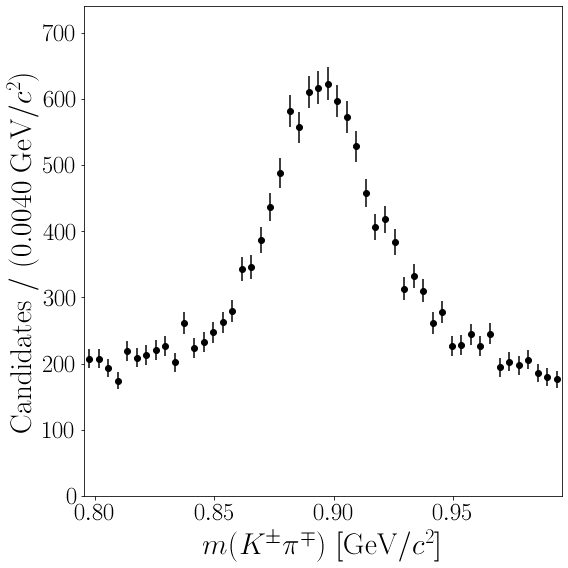

In [38]:
plotting.errorbar_hist(Kst,"mass",f"{file_type}_Kst_M","$m(K^\\pm \\pi^\\mp)$","GeV/$c^2$",PDG_Kst_m-Kst_window,PDG_Kst_m+Kst_window,50)

Make $B$ candidates by combining $K^*$ and $ee$ candidates, and apply a mass cut

In [40]:
B = ak.cartesian({"Kst_k": Kst["k"], "Kst_pi": Kst["pi"], "e1": ee["e_1"], "e2": ee["e_2"]})
B["mass"] = kinematics.mass([B["Kst_k"], B["Kst_pi"], B["e1"], B["e2"]], [PDG_K_m, PDG_pi_m, PDG_e_m, PDG_e_m])

low = 5.22
high = 5.34
B_cut = np.logical_and(B["mass"] > low, B["mass"] < high)
B = B[B_cut]

Recalculate invariant mass for the electron pairs used in the $B$ to get the $q^2$ spectrum

/eos/user/d/dhill/.local/lib/python3.7/site-packages/awkward1/_connect/_numpy.py:101: RuntimeWarning: invalid value encountered in sqrt
  *[nplike.asarray(x) for x in inputs], **kwargs
/eos/user/d/dhill/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/eos/user/d/dhill/.local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


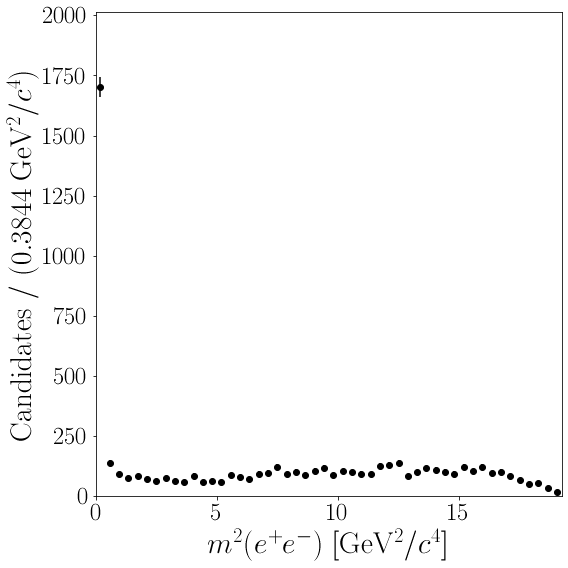

In [44]:
B["ee_m"] = kinematics.mass([B["e1"], B["e2"]], [PDG_e_m, PDG_e_m])
B["q2"] = B["ee_m"]**2

plotting.errorbar_hist(B,"q2",f"{file_type}_q2","$m^2(e^+ e^-)$","GeV$^2$/$c^4$",ee_m_low_cut_val, ee_m_high_cut_val, 50)

Fit the $B$ mass

In [51]:
obs = zfit.Space('mB', limits=(low, high))

rand = random.randint(0,999)
#Signal PDF
B_mu = zfit.Parameter(f"B_mu_{rand}", 5.279, low, high)
B_sigma = zfit.Parameter(f"B_sigma_{rand}", 0.004, 0., 0.1)
B_alphaL = zfit.Parameter(f"B_alphaL_{rand}", 0.5, 0., 5.)
B_nL = zfit.Parameter(f"B_nL_{rand}", 100., 0., 200.)
B_alphaR = zfit.Parameter(f"B_alphaR_{rand}", -0.5, -5., 0.)
B_nR = zfit.Parameter(f"B_nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.3, 0., 1.)

n_sig = zfit.Parameter(f"n_sig_{rand}", 6000., 0., 20000.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaL, n=B_nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=B_mu, sigma=B_sigma, alpha=B_alphaR, n=B_nR)
pdf_sig = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac).create_extended(n_sig)

#Background PDF
comb = zfit.Parameter(f"comb_{rand}", -0.2, -1, 1.)

n_bkg = zfit.Parameter(f"n_bkg_{rand}", 200., 0., 10000.)

pdf_bkg = zfit.pdf.Chebyshev(obs=obs, coeffs=[comb]).create_extended(n_bkg)

#Total PDF
pdf = zfit.pdf.SumPDF([pdf_sig, pdf_bkg])

In [46]:
data_np = ak.to_numpy(ak.flatten(B["mass"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [52]:
nll = zfit.loss.ExtendedUnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit(tolerance=1e-5)
result = minimizer.minimize(nll)
#param_errors, _ = result.errors(method="minuit_minos")
param_errors = result.hesse()

print("m(B) fit function minimum:", result.fmin)
print("m(B) fit converged:", result.converged)
print("m(B) fit full minimizer information:", result.info)

params = result.params
print(params)

n_sig_val = params[n_sig]['value']

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -6.594e+04                 │      Ncalls = 1048 (1048 total)      │
│ EDM = 6.68e-06 (Goal: 1e-05)     │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(B) fit function minimum: -65944.37979725437
m(B) fit converged: True
m(B) fit full minimizer information: {'n_eval': 1048, 'n_iter': 1048, 'original': FMin(fval=-65944.37979725437, edm=6.680330933594809e-06, tolerance=0.01, nfcn=1048, nca

Plot fit result

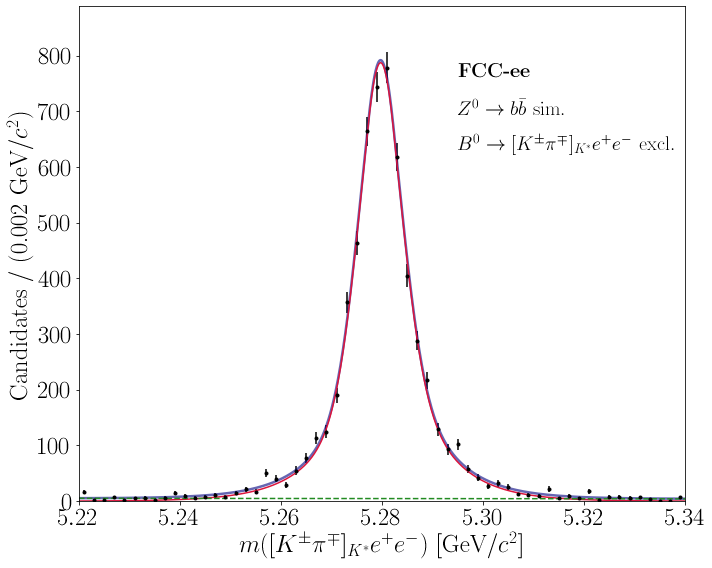

In [53]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.002
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
y_plot_sig = zfit.run(pdf_sig.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_sig*params[n_sig]['value']/bins*obs.area(), color='crimson')
y_plot_bkg = zfit.run(pdf_bkg.pdf(x_plot, norm_range=obs))
plt.plot(x_plot,y_plot_bkg*params[n_bkg]['value']/bins*obs.area(), color='forestgreen', linestyle='dashed')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m([K^\pm \pi^\mp]_{K^*} e^+ e^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(5.295,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(5.295,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(5.295,0.74*ymax,"$B^0 \\to [K^\pm \pi^\mp]_{K^*} e^+ e^-$ excl.",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{file_type}_Bd_M_fit.pdf")